# Классификация состояния активности субъекта исследования

В этом проекте нам предстоит классифицировать снятые с сенсоров 60-секундные последовательности данных, указывая в каком из двух состояний активности был субъект исследования на протяжение каждой последовательности.

## Описание данных

* **train.csv** - тренировочный набор данных, включающий в себя примерно 26 000 60-секундных записей тринадцати биологических сенсоров для почти одной тысячи участников эксперимента
 * sequence - уникальный идентификационный номер каждой последовательности
 * subject - уникальный идентификационный номер каждого субъекта эксперимента
 * step - временной шаг записи, равен одной секунде
 * sensor_00 - sensor_12 - значение каждого из тринадцати сенсоров в данный временной шаг
* **train_labels.csv** - набор целевого признака каждой последовательности
 * sequence - уникальный идентификационный номер каждой последовательности
 * state - состояние относящееся к каждой последовательности. Это наш целевой признак.
* **test.csv** - тестовый набор данных. Для каждой из почти 12 000 последовательностей нам нужно предсказать значение состояния последовательности.
* **sample_submission.csv** - пример предоставляемого файла в требуемом формате

Результаты оцениваются по метрике AUC ROC между прогнозируемой вероятностью и целевым признаком.

 ## Изучение данных

In [1]:
# Загружаем нужные библиотеки.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats

In [2]:
# Загрузим и прочитаем файлы.
features_train = pd.read_csv('data_tabular-playground-series-apr-2022/train.csv')
target_train = pd.read_csv('data_tabular-playground-series-apr-2022/train_labels.csv')
features_test = pd.read_csv('data_tabular-playground-series-apr-2022/test.csv')
sample_submission = pd.read_csv('data_tabular-playground-series-apr-2022/sample_submission.csv')

In [3]:
# Изучим основную информацию о файлах.
def describe_it(dataset):
    info = dataset.info()
    description = dataset.describe()
    image = display(dataset)
    return info, description, image

In [4]:
describe_it(features_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.000000,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.000000,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.000000,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.000000,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.000000,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.282844,-1.217437,-1.666153,0.586726,-0.930698,-0.451010,-0.651184,0.368702,0.4,0.008671,-0.723536,-0.353909,-0.914749
1558076,25967,327,56,0.130603,0.349790,-1.666153,-0.324779,0.775324,-0.332835,0.099271,0.122137,-0.2,0.644509,0.691407,-0.613169,-0.515772
1558077,25967,327,57,-0.579598,0.429622,-1.666153,0.319469,0.308861,0.282723,-0.512750,0.012214,-1.6,-0.424133,0.716855,1.628601,0.928389
1558078,25967,327,58,1.278980,1.711134,-1.522820,0.802655,-0.460541,-0.055348,2.405282,0.043511,1.9,0.283960,-0.914914,0.364198,0.211424


(None,
            sequence       subject          step     sensor_00     sensor_01  \
 count  1.558080e+06  1.558080e+06  1.558080e+06  1.558080e+06  1.558080e+06   
 mean   1.298350e+04  3.316331e+02  2.950000e+01  4.365526e-04 -1.034982e-03   
 std    7.496318e+03  1.958257e+02  1.731811e+01  2.658684e+00  4.404200e+00   
 min    0.000000e+00  0.000000e+00  0.000000e+00 -3.750634e+02 -4.345977e+02   
 25%    6.491750e+03  1.617500e+02  1.475000e+01 -5.000000e-01 -4.831933e-01   
 50%    1.298350e+04  3.350000e+02  2.950000e+01 -3.091190e-03  3.151261e-03   
 75%    1.947525e+04  5.010000e+02  4.425000e+01  4.845440e-01  4.926471e-01   
 max    2.596700e+04  6.710000e+02  5.900000e+01  3.358246e+02  4.495914e+02   
 
           sensor_02     sensor_03     sensor_04     sensor_05     sensor_06  \
 count  1.558080e+06  1.558080e+06  1.558080e+06  1.558080e+06  1.558080e+06   
 mean  -2.178045e-01 -2.156555e-03 -1.828903e-03 -1.651785e-03 -4.122917e-04   
 std    2.298002e+00  3.934184e

In [5]:
describe_it(target_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25968 entries, 0 to 25967
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sequence  25968 non-null  int64
 1   state     25968 non-null  int64
dtypes: int64(2)
memory usage: 405.9 KB


,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
25963,25963,1
25964,25964,0
25965,25965,1
25966,25966,1


(None,
            sequence         state
 count  25968.000000  25968.000000
 mean   12983.500000      0.501155
 std     7496.460231      0.500008
 min        0.000000      0.000000
 25%     6491.750000      0.000000
 50%    12983.500000      1.000000
 75%    19475.250000      1.000000
 max    25967.000000      1.000000,
 None)

In [6]:
describe_it(features_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733080 entries, 0 to 733079
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sequence   733080 non-null  int64  
 1   subject    733080 non-null  int64  
 2   step       733080 non-null  int64  
 3   sensor_00  733080 non-null  float64
 4   sensor_01  733080 non-null  float64
 5   sensor_02  733080 non-null  float64
 6   sensor_03  733080 non-null  float64
 7   sensor_04  733080 non-null  float64
 8   sensor_05  733080 non-null  float64
 9   sensor_06  733080 non-null  float64
 10  sensor_07  733080 non-null  float64
 11  sensor_08  733080 non-null  float64
 12  sensor_09  733080 non-null  float64
 13  sensor_10  733080 non-null  float64
 14  sensor_11  733080 non-null  float64
 15  sensor_12  733080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 89.5 MB


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.00000,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.00000,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.00000,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.00000,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.00000,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733075,38185,773,55,0.211747,2.005252,-1.33282,0.695575,-0.161327,-1.193717,0.421676,0.869466,0.0,-1.536850,0.388101,2.205761,-91.610827
733076,38185,773,56,-0.826121,-2.468487,-1.33282,0.381416,0.144745,1.060583,-0.765938,0.288550,0.2,-1.956647,-0.032158,-1.794239,72.414749
733077,38185,773,57,0.755023,1.469538,-1.33282,-1.253097,-0.414802,0.007479,0.907104,-1.556489,0.4,4.341763,0.150273,0.641975,-34.065644
733078,38185,773,58,-0.187017,0.714286,-1.33282,0.077876,1.323245,0.159312,-0.397996,0.306870,0.1,-1.013728,-0.608616,0.317901,65.659420


(None,
             sequence        subject           step      sensor_00  \
 count  733080.000000  733080.000000  733080.000000  733080.000000   
 mean    32076.500000     829.363971      29.500000       0.000208   
 std      3527.035188      92.611544      17.318114       2.927126   
 min     25968.000000     672.000000       0.000000    -347.382535   
 25%     29022.000000     750.000000      14.750000      -0.497682   
 50%     32076.500000     833.000000      29.500000      -0.003864   
 75%     35131.000000     909.000000      44.250000       0.480680   
 max     38185.000000     990.000000      59.000000     403.787481   
 
            sensor_01      sensor_02      sensor_03      sensor_04  \
 count  733080.000000  733080.000000  733080.000000  733080.000000   
 mean       -0.001046      -0.218273      -0.002449      -0.000155   
 std         4.595209       2.336926       4.883734       1.880884   
 min      -457.260504     -31.659476    -425.277876     -24.754551   
 25%       

In [7]:
# Посмотрим, как должен выглядеть предоставляемый файл.
display(sample_submission)

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0
...,...,...
12213,38181,0
12214,38182,0
12215,38183,0
12216,38184,0


## Обработка данных

Датасеты не имеют пропусков. Изучим их на наличие дубликатов.

In [8]:
# Посчитаем количество полных дубликатов.
print('Количество полных дубликатов в датасете features_train составляет:',
     features_train.duplicated().sum())

Количество полных дубликатов в датасете features_train составляет: 0


Посчитаем количество последовательностей и субъектов. Проверим количество шагов.

In [9]:
# Каждая последовательность встречается 60 раз, как и должно быть.
display(features_train['sequence'].value_counts().sort_index())

0        60
1        60
2        60
3        60
4        60
         ..
25963    60
25964    60
25965    60
25966    60
25967    60
Name: sequence, Length: 25968, dtype: int64

Посмотрим, сколько субъектов мы имеем.

In [10]:
# Мы имеем 672 субъета.
display(features_train['subject'].value_counts().sort_index())

0       1200
1      10500
2       2280
3       2160
4       1560
       ...  
667     3720
668     1260
669     1500
670     1680
671     3600
Name: subject, Length: 672, dtype: int64

In [11]:
# У каждой последовательности 60 шагов. Всё верно.
display(features_train['step'].value_counts().sort_index())

0     25968
1     25968
2     25968
3     25968
4     25968
5     25968
6     25968
7     25968
8     25968
9     25968
10    25968
11    25968
12    25968
13    25968
14    25968
15    25968
16    25968
17    25968
18    25968
19    25968
20    25968
21    25968
22    25968
23    25968
24    25968
25    25968
26    25968
27    25968
28    25968
29    25968
30    25968
31    25968
32    25968
33    25968
34    25968
35    25968
36    25968
37    25968
38    25968
39    25968
40    25968
41    25968
42    25968
43    25968
44    25968
45    25968
46    25968
47    25968
48    25968
49    25968
50    25968
51    25968
52    25968
53    25968
54    25968
55    25968
56    25968
57    25968
58    25968
59    25968
Name: step, dtype: int64

In [12]:
# Посчитаем, сколько последовательностей у каждого субъекта
# в тренировочной выборке.
sequences_train = features_train.groupby('subject')['sequence']\
.nunique().reset_index()
sequences_train.columns = ['subject', 'sequence_count']
display(sequences_train)

,subject,sequence_count
0,0,20
1,1,175
2,2,38
3,3,36
4,4,26
...,...,...
667,667,62
668,668,21
669,669,25
670,670,28


In [13]:
# Посчитаем, сколько последовательностей у каждого субъекта
# в тестовой выборке.
sequences_test = features_test.groupby('subject')['sequence']\
.nunique().reset_index()
sequences_test.columns = ['subject', 'sequence_count']
display(sequences_test)

,subject,sequence_count
0,672,24
1,673,32
2,674,27
3,675,43
4,676,30
...,...,...
314,986,39
315,987,13
316,988,20
317,989,28


### Вывод

Нам удалось выяснить следующее про датасет features_train:
* Датасет не имеет полных дубликатов и пропусков
* Всего 25 968 последовательностей и 672 субъекта
* У каждой последовательности 60 шагов  

Также мы посчитали количество последовательностей для каждого субъекта в обоих выборках.

## Исследовательский анализ данных

In [14]:
# Исследуем сбалансированность классов.
print('Частотность классов:')
target_train['state'].value_counts(normalize=True)

Частотность классов:


1    0.501155
0    0.498845
Name: state, dtype: float64

Классы сбалансированы, что несомненно хорошо.

In [15]:
# Сохраним названия столбцов сенсоров.
sensors = features_train.columns[3:]
sns.set(rc = {'figure.figsize':(16,8)})
sns.set_theme(style='darkgrid')
# Напишем функцию для исследования распределения данных.
def research(dataset, sensor_name):
    ax = sns.boxplot(x=dataset[sensor_name])
    plt.title('Диаграмма размаха значений столбца ' + str(sensor_name))
    plt.show()

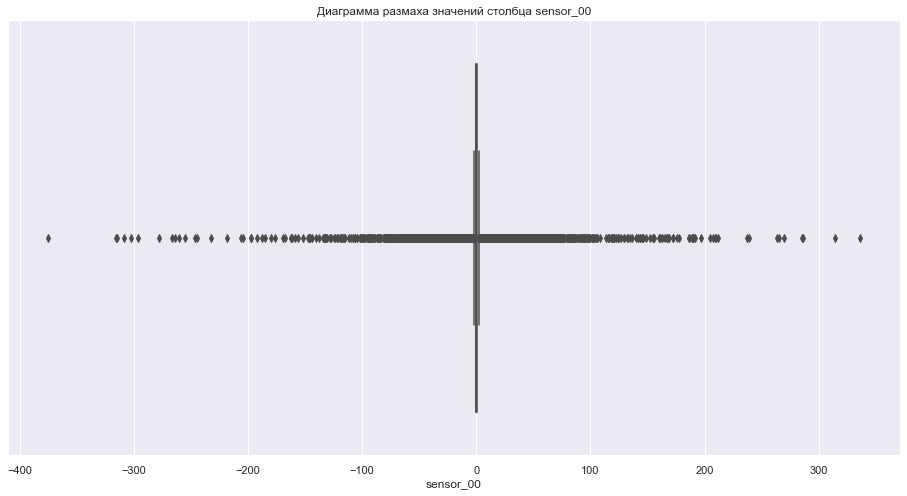

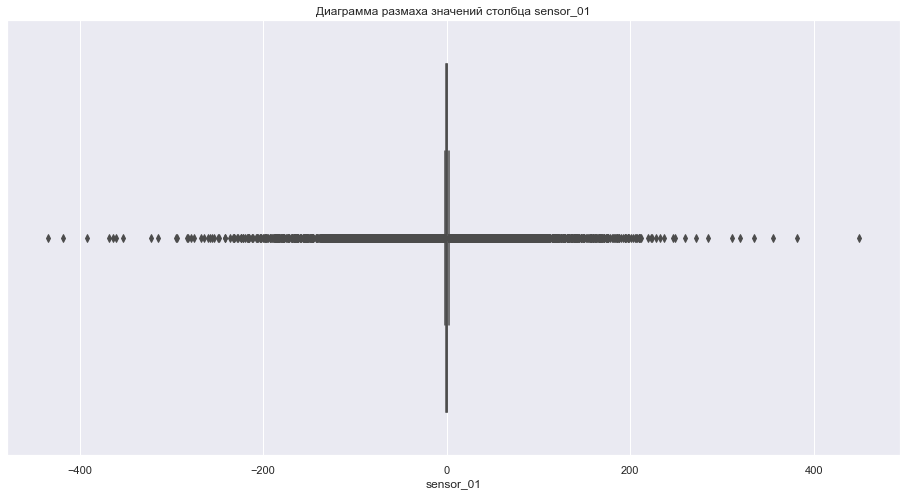

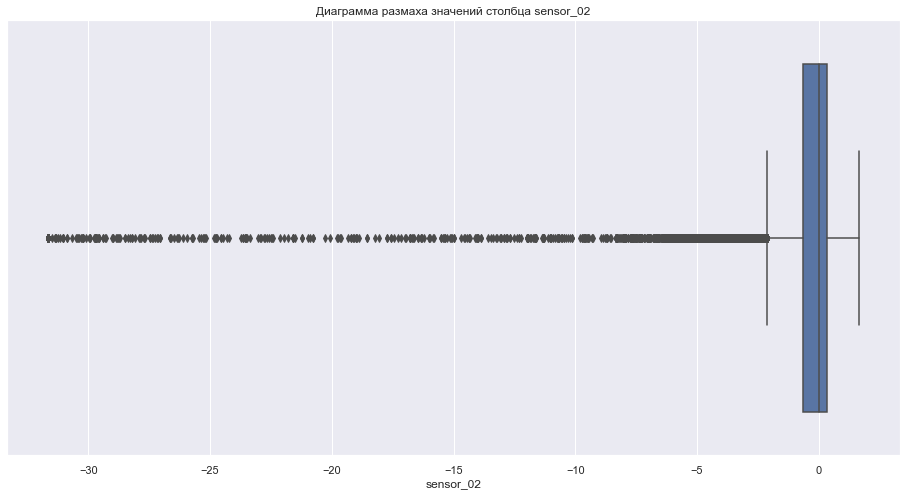

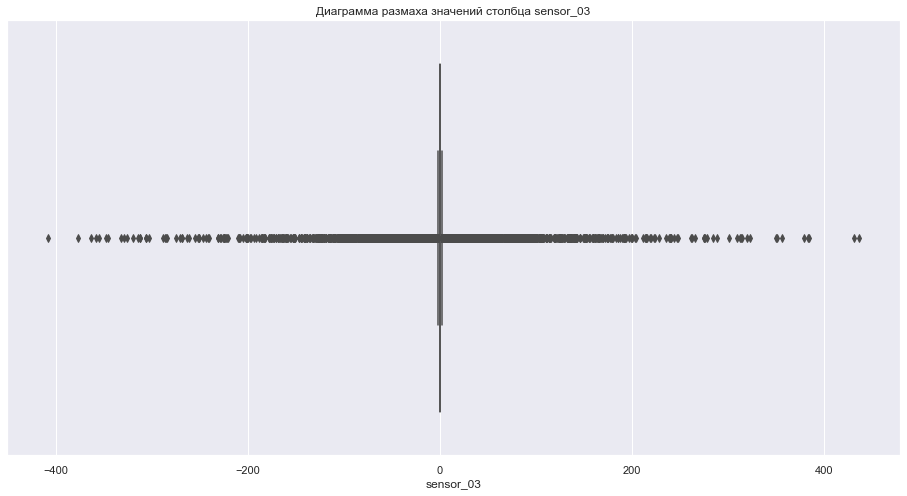

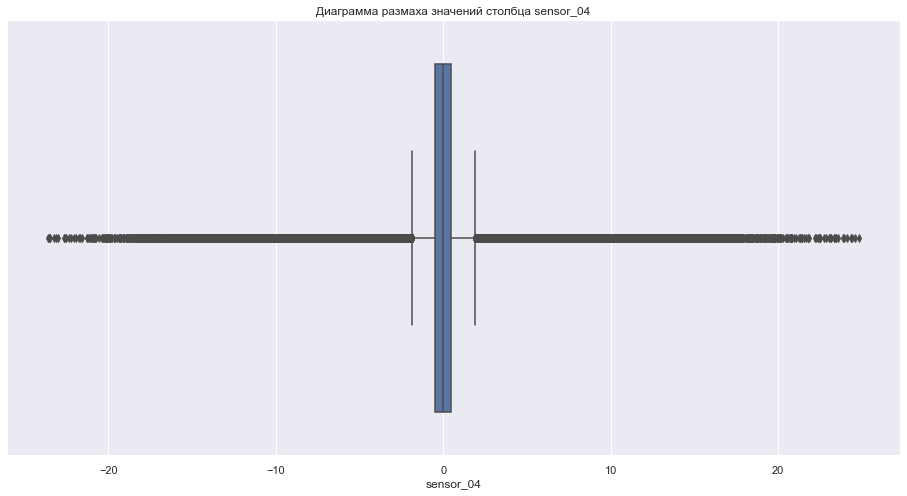

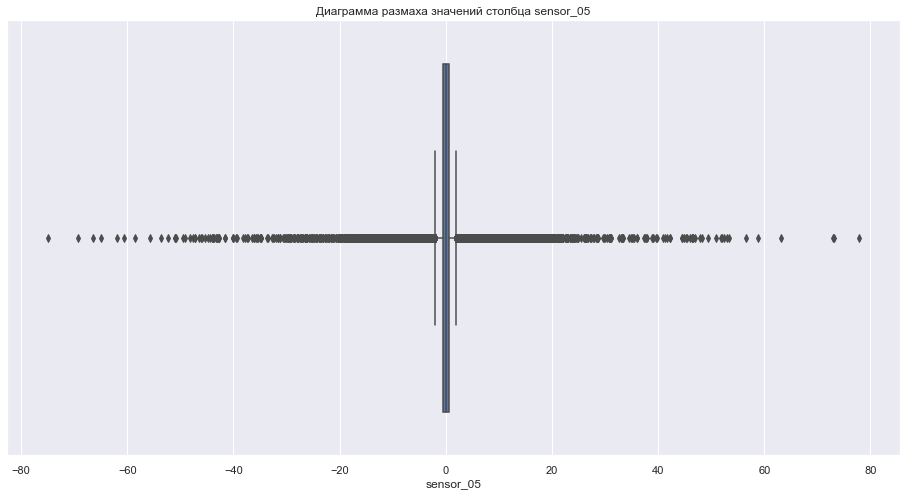

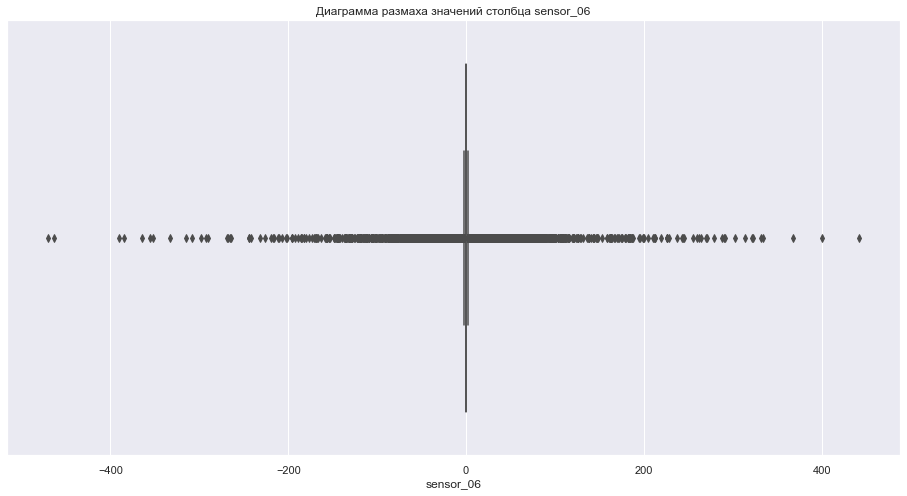

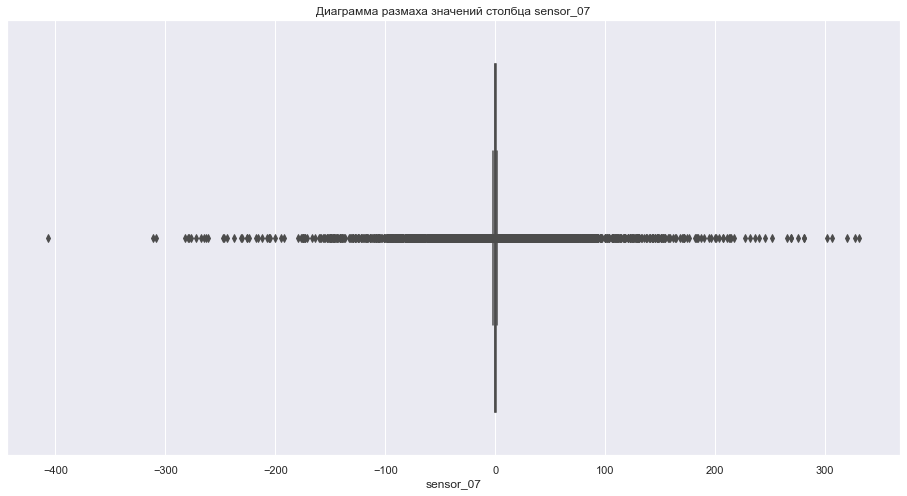

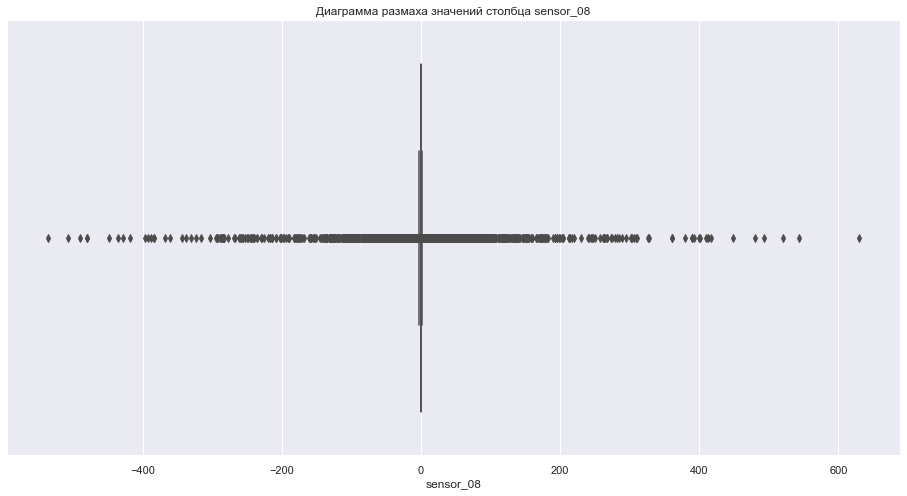

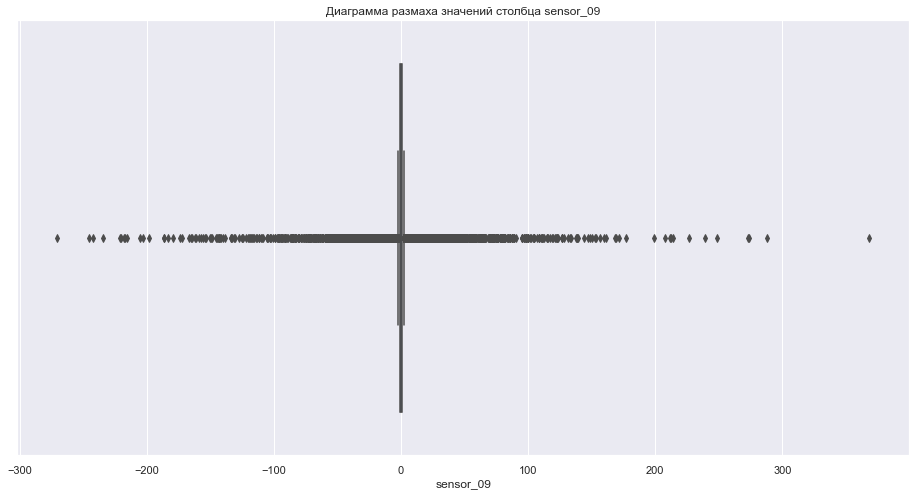

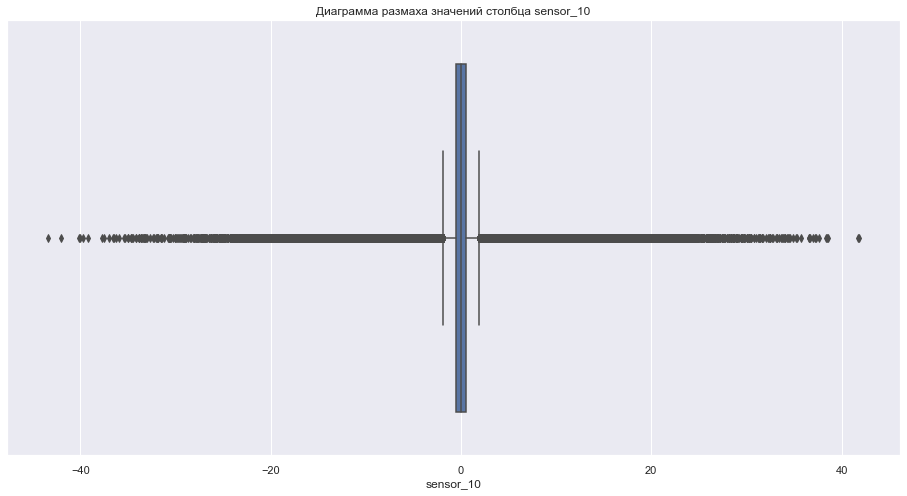

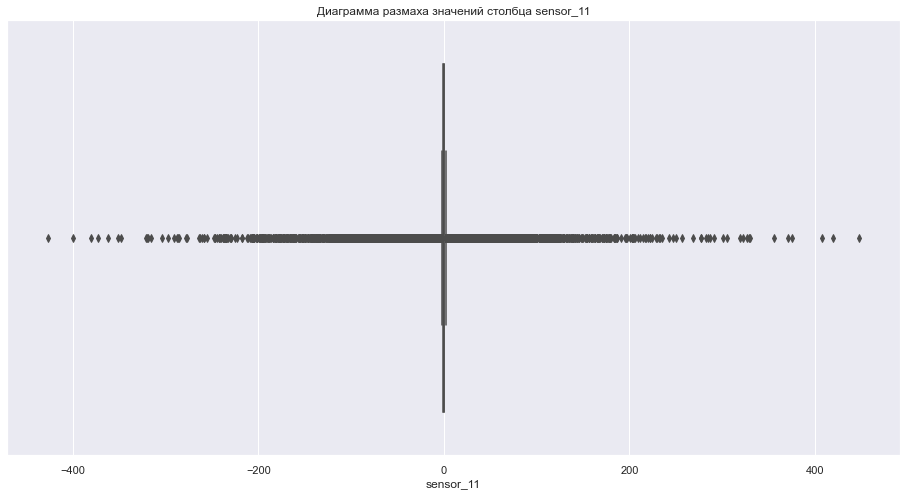

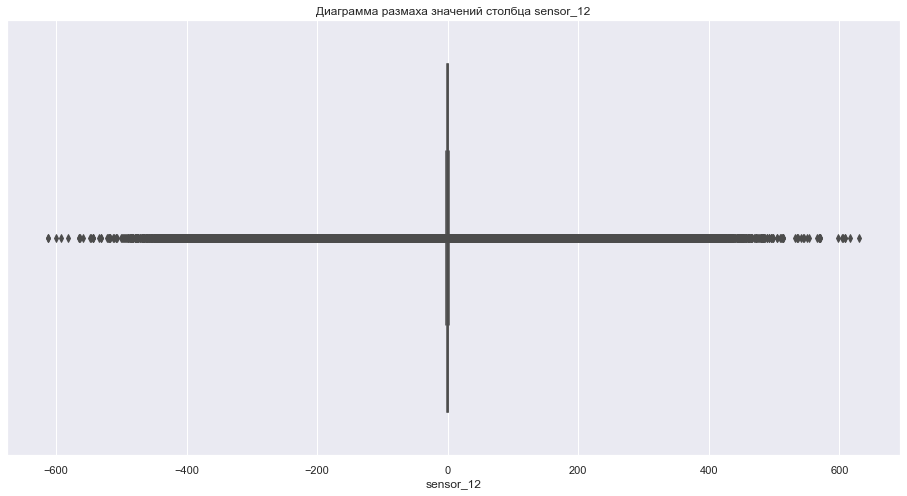

In [16]:
# Взглянем на диаграммы размаха значений показаний сенсоров.
for sensor in sensors:
    research(features_train, sensor)

Мы не знаем, что именно измеряли сенсоры, поэтому мы не можем понять природу этих численных значений. Стало быть мы не можем корректно провести анализ выбросов и аномалий без риска сделать нашу модель искусственной и нечувствительной к всему охвату реальных значений. Но мы предполагаем, что абсурдных выбросов, которые нужно удалить, нет (судя по диаграммам размаха).

## Группировка данных. Создание признаков.

Нам нужно провести группировку данных по ключу — номеру последовательности. Также попробуем создать дополнительные признаки. Посчитаем для каждого сенсора каждой последовательности:  
* Минимальное и максимальное значения
* Первое и последнее значения
* Стандартное отклонение
* Среднее значение, медиану
* Коэффициент эксцесса
* Интерквартильный размах

In [17]:
# Проведем группировку тренировочного набора.
features_train_copy = features_train.copy()
features_train_copy_grouped = features_train_copy.pivot_table(
    index=['sequence', 'subject'], 
    values=features_train_copy.columns[3:], 
    aggfunc=[
        'min',
        'max',
        'first',
        'last',
        'std',
        'mean',
        'median',
        scipy.stats.kurtosis,
        scipy.stats.iqr
    ])
# Избавимся от мультииндекса.
names = features_train_copy_grouped.columns
new_names = []
for i in range(len(names)):
    new_names.append('_'.join(list(names[i])))
features_train_copy_grouped.columns = new_names
features_train_copy_grouped = features_train_copy_grouped.reset_index()

In [18]:
# Взглянем на таблицу.
display(features_train_copy_grouped)

,sequence,subject,min_sensor_00,min_sensor_01,min_sensor_02,min_sensor_03,min_sensor_04,min_sensor_05,min_sensor_06,min_sensor_07,...,iqr_sensor_03,iqr_sensor_04,iqr_sensor_05,iqr_sensor_06,iqr_sensor_07,iqr_sensor_08,iqr_sensor_09,iqr_sensor_10,iqr_sensor_11,iqr_sensor_12
0,0,47,-5.634467,-3.002101,0.666667,-3.163717,-1.604398,-1.389678,-2.373406,-6.323664,...,1.081858,1.073487,0.653328,1.425319,0.965649,1.425,1.309249,1.247553,1.341049,6.099957
1,1,66,-6.657651,-2.745798,-2.647306,-4.506195,-1.417513,-6.744203,-4.568306,-4.669466,...,1.188053,1.084411,1.530853,0.888434,1.037977,1.300,1.024566,0.884557,1.069187,0.396526
2,2,66,-2.797527,-1.733193,-1.332820,-1.751327,-8.250281,-6.978310,-2.040984,-5.987023,...,1.397124,1.444341,1.073485,1.010929,2.752863,1.175,0.787030,0.737545,0.787037,0.356991
3,3,542,-3.643740,-5.860294,0.333847,-5.076991,-0.698962,-3.448018,-4.825137,-6.142748,...,1.440265,0.311643,1.517390,1.559426,1.513740,2.400,3.703215,0.379938,1.101852,0.233163
4,4,437,-5.331530,-5.898109,0.666667,-5.426549,-1.124221,-4.643231,-13.400729,-5.167939,...,2.233407,0.840921,2.471017,1.891849,1.809733,1.150,1.124819,0.605028,2.761831,0.057971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,-3.738022,-4.287815,-0.332820,-5.743363,-0.759101,-2.918474,-4.484517,-3.290076,...,2.554425,0.266324,1.239529,1.407559,1.764122,1.225,1.250000,0.255991,4.388632,0.093564
25964,25964,297,-5.220247,-3.253151,-0.666153,-1.182301,-1.582502,-3.022438,-5.226776,-1.463359,...,0.977655,1.493836,2.029918,1.195583,0.866985,9.925,0.889451,1.681973,0.842335,26.831415
25965,25965,129,-3.422720,-2.378151,-0.999486,-2.559292,-2.813053,-1.212416,-2.779599,-6.821374,...,1.375885,1.097884,0.816567,1.248634,5.087786,1.450,3.593208,3.695677,2.104424,1.288150
25966,25966,170,-2.069552,-34.113445,-0.999486,-5.168142,-3.565188,-0.467464,-3.469945,-4.683969,...,1.622566,1.463607,0.278422,1.214936,1.062595,1.000,0.636019,3.111971,2.037037,26.109974


In [19]:
# Добавим в таблицу количество последовательностей у субъектов.
features_train_copy_grouped = features_train_copy_grouped.reset_index().merge(
    sequences_train, how='left', on='subject')

In [20]:
# Взглянем на таблицу.
display(features_train_copy_grouped)

,index,sequence,subject,min_sensor_00,min_sensor_01,min_sensor_02,min_sensor_03,min_sensor_04,min_sensor_05,min_sensor_06,...,iqr_sensor_04,iqr_sensor_05,iqr_sensor_06,iqr_sensor_07,iqr_sensor_08,iqr_sensor_09,iqr_sensor_10,iqr_sensor_11,iqr_sensor_12,sequence_count
0,0,0,47,-5.634467,-3.002101,0.666667,-3.163717,-1.604398,-1.389678,-2.373406,...,1.073487,0.653328,1.425319,0.965649,1.425,1.309249,1.247553,1.341049,6.099957,104
1,1,1,66,-6.657651,-2.745798,-2.647306,-4.506195,-1.417513,-6.744203,-4.568306,...,1.084411,1.530853,0.888434,1.037977,1.300,1.024566,0.884557,1.069187,0.396526,28
2,2,2,66,-2.797527,-1.733193,-1.332820,-1.751327,-8.250281,-6.978310,-2.040984,...,1.444341,1.073485,1.010929,2.752863,1.175,0.787030,0.737545,0.787037,0.356991,28
3,3,3,542,-3.643740,-5.860294,0.333847,-5.076991,-0.698962,-3.448018,-4.825137,...,0.311643,1.517390,1.559426,1.513740,2.400,3.703215,0.379938,1.101852,0.233163,83
4,4,4,437,-5.331530,-5.898109,0.666667,-5.426549,-1.124221,-4.643231,-13.400729,...,0.840921,2.471017,1.891849,1.809733,1.150,1.124819,0.605028,2.761831,0.057971,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,25963,558,-3.738022,-4.287815,-0.332820,-5.743363,-0.759101,-2.918474,-4.484517,...,0.266324,1.239529,1.407559,1.764122,1.225,1.250000,0.255991,4.388632,0.093564,43
25964,25964,25964,297,-5.220247,-3.253151,-0.666153,-1.182301,-1.582502,-3.022438,-5.226776,...,1.493836,2.029918,1.195583,0.866985,9.925,0.889451,1.681973,0.842335,26.831415,32
25965,25965,25965,129,-3.422720,-2.378151,-0.999486,-2.559292,-2.813053,-1.212416,-2.779599,...,1.097884,0.816567,1.248634,5.087786,1.450,3.593208,3.695677,2.104424,1.288150,28
25966,25966,25966,170,-2.069552,-34.113445,-0.999486,-5.168142,-3.565188,-0.467464,-3.469945,...,1.463607,0.278422,1.214936,1.062595,1.000,0.636019,3.111971,2.037037,26.109974,88


In [21]:
# Создадим функцию для проверки признаков на мультиколлинеарность.
def vif(features):
    vif_dataset = pd.DataFrame()
    vif_dataset['Признак'] = features.columns
    vif_dataset['VIF'] = [variance_inflation_factor(
            features.values, i) for i in range(features.shape[1])]
    
    return vif_dataset

In [22]:
# Проверяем.
pd.set_option('display.max_rows', None)
vif(features_train_copy_grouped.iloc[:, 3:])

,Признак,VIF
0,min_sensor_00,35.738321
1,min_sensor_01,39.246064
2,min_sensor_02,19.096615
3,min_sensor_03,34.405572
4,min_sensor_04,32.612053
5,min_sensor_05,26.081555
6,min_sensor_06,23.677014
7,min_sensor_07,28.333568
8,min_sensor_08,31.501150
9,min_sensor_09,34.077699


In [23]:
# Удалим признаки с минимальными значениями и оценим
# мультиколлинеарность.
features_train_copy_grouped = features_train_copy_grouped.drop(
    features_train_copy_grouped.columns[0:16], 
    axis=1
)
vif(features_train_copy_grouped)

,Признак,VIF
0,max_sensor_00,32.611028
1,max_sensor_01,22.568539
2,max_sensor_02,32.372072
3,max_sensor_03,28.296970
4,max_sensor_04,28.941550
5,max_sensor_05,23.221170
6,max_sensor_06,25.640123
7,max_sensor_07,29.002509
8,max_sensor_08,38.346440
9,max_sensor_09,26.631293


In [24]:
# Удалим признаки с максимальными значениями и оценим
# мультиколлинеарность.
features_train_copy_grouped = features_train_copy_grouped.drop(
    features_train_copy_grouped.columns[0:13], 
    axis=1
)
vif(features_train_copy_grouped)

,Признак,VIF
0,first_sensor_00,2.153223
1,first_sensor_01,1.948693
2,first_sensor_02,4.876751
3,first_sensor_03,2.210639
4,first_sensor_04,1.093773
5,first_sensor_05,1.106183
6,first_sensor_06,2.434388
7,first_sensor_07,1.894888
8,first_sensor_08,1.133035
9,first_sensor_09,2.032668


In [25]:
# Удалим признаки стандартного отклонения 4, 5, 10 и 12 сенсоров.
features_train_copy_grouped = features_train_copy_grouped.drop(
    features_train_copy_grouped.columns[[30, 31, 36, 38]], 
    axis=1
)
vif(features_train_copy_grouped)

,Признак,VIF
0,first_sensor_00,2.153180
1,first_sensor_01,1.948473
2,first_sensor_02,4.875552
3,first_sensor_03,2.210376
4,first_sensor_04,1.092137
5,first_sensor_05,1.106066
6,first_sensor_06,2.433811
7,first_sensor_07,1.894328
8,first_sensor_08,1.132762
9,first_sensor_09,2.032178


In [26]:
# Удалим признак среднего значения 2 сенсора.
features_train_copy_grouped = features_train_copy_grouped.drop(
    features_train_copy_grouped.columns[37], 
    axis=1
)
vif(features_train_copy_grouped)

,Признак,VIF
0,first_sensor_00,2.153177
1,first_sensor_01,1.948249
2,first_sensor_02,4.373472
3,first_sensor_03,2.210317
4,first_sensor_04,1.091952
5,first_sensor_05,1.106052
6,first_sensor_06,2.433585
7,first_sensor_07,1.894327
8,first_sensor_08,1.132234
9,first_sensor_09,2.031559


In [27]:
# Удалим признак медианы 2 сенсора.
features_train_copy_grouped = features_train_copy_grouped.drop(
    features_train_copy_grouped.columns[49], 
    axis=1
)
vif(features_train_copy_grouped)

,Признак,VIF
0,first_sensor_00,2.152963
1,first_sensor_01,1.947947
2,first_sensor_02,2.374587
3,first_sensor_03,2.210309
4,first_sensor_04,1.091880
5,first_sensor_05,1.105832
6,first_sensor_06,2.433490
7,first_sensor_07,1.894269
8,first_sensor_08,1.131527
9,first_sensor_09,2.031530


In [28]:
# Удалим признаки межквартильного размаха 0, 3, 7, 9, 11 сенсоров.
features_train_copy_grouped = features_train_copy_grouped.drop(
    features_train_copy_grouped.columns[[72, 75, 79, 81, 83]], 
    axis=1
)
vif(features_train_copy_grouped)

,Признак,VIF
0,first_sensor_00,2.146415
1,first_sensor_01,1.940184
2,first_sensor_02,2.373812
3,first_sensor_03,2.202889
4,first_sensor_04,1.091591
5,first_sensor_05,1.105716
6,first_sensor_06,2.423718
7,first_sensor_07,1.891566
8,first_sensor_08,1.131160
9,first_sensor_09,2.030887


In [29]:
# Проведем группировку тестового набора.
features_test_copy = features_test.copy()
features_test_copy_grouped = features_test_copy.pivot_table(
    index=['sequence', 'subject'], 
    values=features_test_copy.columns[3:], 
    aggfunc=[
        'first',
        'last',
        'std',
        'mean',
        'median',
        scipy.stats.kurtosis,
        scipy.stats.iqr
    ])
# Избавимся от мультииндекса.
names = features_test_copy_grouped.columns
new_names = []
for i in range(len(names)):
    new_names.append('_'.join(list(names[i])))
features_test_copy_grouped.columns = new_names
features_test_copy_grouped = features_test_copy_grouped.reset_index()

In [30]:
pd.set_option('display.max_rows', 60)
display(features_test_copy_grouped)

,sequence,subject,first_sensor_00,first_sensor_01,first_sensor_02,first_sensor_03,first_sensor_04,first_sensor_05,first_sensor_06,first_sensor_07,...,iqr_sensor_03,iqr_sensor_04,iqr_sensor_05,iqr_sensor_06,iqr_sensor_07,iqr_sensor_08,iqr_sensor_09,iqr_sensor_10,iqr_sensor_11,iqr_sensor_12
0,25968,684,2.427357,19.639706,1.000000,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,...,0.905088,1.001547,2.614435,0.778005,1.112023,2.250,0.952854,0.615995,1.048868,0.439258
1,25969,935,-0.278207,0.086134,0.333847,1.407080,0.381966,0.881077,0.133880,0.509924,...,1.297566,1.000206,0.843119,1.082195,1.253053,0.900,0.688764,0.618827,0.980453,1.062553
2,25970,924,2.746522,-3.620798,-0.666153,-1.769912,-1.931399,-0.326103,-2.204918,1.845802,...,2.630088,2.992878,0.245138,4.095856,2.297901,0.725,2.352782,5.706731,3.298611,31.323423
3,25971,769,-0.634467,-0.579832,-0.666153,-0.365487,0.315329,0.160060,-0.601093,-0.351145,...,1.248451,0.695674,1.022999,0.761612,0.705153,0.800,0.564848,0.413716,0.558128,1.598998
4,25972,764,-0.545595,-0.696429,0.000000,0.230973,0.781620,-0.756918,-1.556466,0.641221,...,0.739381,2.441260,1.663613,0.960155,0.936450,1.000,1.001445,4.298331,0.967850,248.652387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12213,38181,980,0.109737,-1.059874,0.333847,0.484071,-2.137717,-1.153328,0.992714,0.383206,...,1.132743,2.481942,0.856956,0.927368,1.057061,3.500,0.891077,17.951415,1.331276,149.814791
12214,38182,915,-12.041731,32.420168,1.000000,7.517699,1.107125,-0.632760,-13.645719,2.521374,...,0.723009,1.438790,1.320307,0.852231,0.837786,0.725,0.759032,0.664086,0.891975,0.325128
12215,38183,872,0.463679,1.089286,-0.666153,0.815929,0.126808,0.620793,0.843352,0.839695,...,1.190708,0.412499,0.560209,1.271403,1.112214,0.950,0.759032,0.791439,1.207562,0.907502
12216,38184,835,-5.665379,-4.713235,0.666667,-2.762832,0.211492,0.503366,-6.950820,-2.930534,...,3.925000,0.636228,1.248878,3.765255,3.315076,0.500,3.149386,2.482694,3.501800,0.775789


In [31]:
# Добавим в таблицу количество последовательностей у субъектов.
features_test_copy_grouped = features_test_copy_grouped.reset_index().merge(
    sequences_test, how='left', on='subject')

In [32]:
# Взглянем на таблицу.
display(features_test_copy_grouped)

,index,sequence,subject,first_sensor_00,first_sensor_01,first_sensor_02,first_sensor_03,first_sensor_04,first_sensor_05,first_sensor_06,...,iqr_sensor_04,iqr_sensor_05,iqr_sensor_06,iqr_sensor_07,iqr_sensor_08,iqr_sensor_09,iqr_sensor_10,iqr_sensor_11,iqr_sensor_12,sequence_count
0,0,25968,684,2.427357,19.639706,1.000000,-1.466372,-1.289973,-4.207928,2.486339,...,1.001547,2.614435,0.778005,1.112023,2.250,0.952854,0.615995,1.048868,0.439258,70
1,1,25969,935,-0.278207,0.086134,0.333847,1.407080,0.381966,0.881077,0.133880,...,1.000206,0.843119,1.082195,1.253053,0.900,0.688764,0.618827,0.980453,1.062553,59
2,2,25970,924,2.746522,-3.620798,-0.666153,-1.769912,-1.931399,-0.326103,-2.204918,...,2.992878,0.245138,4.095856,2.297901,0.725,2.352782,5.706731,3.298611,31.323423,38
3,3,25971,769,-0.634467,-0.579832,-0.666153,-0.365487,0.315329,0.160060,-0.601093,...,0.695674,1.022999,0.761612,0.705153,0.800,0.564848,0.413716,0.558128,1.598998,70
4,4,25972,764,-0.545595,-0.696429,0.000000,0.230973,0.781620,-0.756918,-1.556466,...,2.441260,1.663613,0.960155,0.936450,1.000,1.001445,4.298331,0.967850,248.652387,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12213,12213,38181,980,0.109737,-1.059874,0.333847,0.484071,-2.137717,-1.153328,0.992714,...,2.481942,0.856956,0.927368,1.057061,3.500,0.891077,17.951415,1.331276,149.814791,42
12214,12214,38182,915,-12.041731,32.420168,1.000000,7.517699,1.107125,-0.632760,-13.645719,...,1.438790,1.320307,0.852231,0.837786,0.725,0.759032,0.664086,0.891975,0.325128,36
12215,12215,38183,872,0.463679,1.089286,-0.666153,0.815929,0.126808,0.620793,0.843352,...,0.412499,0.560209,1.271403,1.112214,0.950,0.759032,0.791439,1.207562,0.907502,46
12216,12216,38184,835,-5.665379,-4.713235,0.666667,-2.762832,0.211492,0.503366,-6.950820,...,0.636228,1.248878,3.765255,3.315076,0.500,3.149386,2.482694,3.501800,0.775789,69


In [33]:
# Уберем лишние столбцы.
training_columns = features_train_copy_grouped.columns
features_test_copy_grouped = features_test_copy_grouped.loc[:, training_columns]
display(features_test_copy_grouped)

,first_sensor_00,first_sensor_01,first_sensor_02,first_sensor_03,first_sensor_04,first_sensor_05,first_sensor_06,first_sensor_07,first_sensor_08,first_sensor_09,...,kurtosis_sensor_12,iqr_sensor_01,iqr_sensor_02,iqr_sensor_04,iqr_sensor_05,iqr_sensor_06,iqr_sensor_08,iqr_sensor_10,iqr_sensor_12,sequence_count
0,2.427357,19.639706,1.000000,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,...,-0.293747,0.990284,0.333333,1.001547,2.614435,0.778005,2.250,0.615995,0.439258,70
1,-0.278207,0.086134,0.333847,1.407080,0.381966,0.881077,0.133880,0.509924,1.1,-0.361272,...,-1.044935,1.079832,0.105579,1.000206,0.843119,1.082195,0.900,0.618827,1.062553,59
2,2.746522,-3.620798,-0.666153,-1.769912,-1.931399,-0.326103,-2.204918,1.845802,-0.6,-0.916185,...,-1.158939,4.217700,0.000000,2.992878,0.245138,4.095856,0.725,5.706731,31.323423,38
3,-0.634467,-0.579832,-0.666153,-0.365487,0.315329,0.160060,-0.601093,-0.351145,-0.7,-0.151734,...,-0.497098,1.095063,0.147917,0.695674,1.022999,0.761612,0.800,0.413716,1.598998,70
4,-0.545595,-0.696429,0.000000,0.230973,0.781620,-0.756918,-1.556466,0.641221,-0.6,-1.216763,...,-0.731940,1.266544,0.332820,2.441260,1.663613,0.960155,1.000,4.298331,248.652387,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12213,0.109737,-1.059874,0.333847,0.484071,-2.137717,-1.153328,0.992714,0.383206,0.5,-1.807803,...,-1.139601,0.904149,0.666667,2.481942,0.856956,0.927368,3.500,17.951415,149.814791,42
12214,-12.041731,32.420168,1.000000,7.517699,1.107125,-0.632760,-13.645719,2.521374,-0.1,-11.429191,...,9.244617,0.972426,0.333333,1.438790,1.320307,0.852231,0.725,0.664086,0.325128,36
12215,0.463679,1.089286,-0.666153,0.815929,0.126808,0.620793,0.843352,0.839695,0.6,0.460260,...,-0.931616,0.845326,0.490591,0.412499,0.560209,1.271403,0.950,0.791439,0.907502,46
12216,-5.665379,-4.713235,0.666667,-2.762832,0.211492,0.503366,-6.950820,-2.930534,0.0,-5.201590,...,-1.304581,3.518645,0.021633,0.636228,1.248878,3.765255,0.500,2.482694,0.775789,69


In [34]:
# Проверим размеры тренировочного и тестового наборов.
display(features_train_copy_grouped.shape)
display(features_test_copy_grouped.shape)

(25968, 81)

(12218, 81)

## Создание и обучение модели

In [35]:
# Создадим признаки.
X = features_train_copy_grouped
y = target_train['state']
X_test = features_test_copy_grouped

In [36]:
# Разобьем выборку на тренировочную и валидационную.
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, train_size=0.75, random_state=12345
)

In [37]:
# Проверим размеры.
sets = [X_train, X_validation, y_train, y_validation]
set_names = ['X_train', 'X_validation', 'y_train', 'y_validation']
for set_name,set in zip(set_names, sets):
    print(f'Размер выборки {set_name} равен {set.shape}')

Размер выборки X_train равен (19476, 81)
Размер выборки X_validation равен (6492, 81)
Размер выборки y_train равен (19476,)
Размер выборки y_validation равен (6492,)


In [38]:
%%time
# Создадим модель градиентного бустинга
# при помощи библиотеки Light GBM.
model_gb = lgb.LGBMClassifier(random_state=12345)
param_grid = {
    'boosting_type': ['gbdt'],
    'max_depth' : [2, 3, 4, 5, 6, 7],
    'n_estimators' : [20, 50, 70, 100, 130, 150, 160, 180, 210, 250, 300],
    'learning_rate' : [0.001, 0.003, 0.01, 0.03, 0.05, 0.015, 0.1, 0.3]
}
# Подберем гиперпараметры.
grid_cv_gb = GridSearchCV(estimator=model_gb, 
                          param_grid=param_grid, 
                          scoring='roc_auc',
                          cv=5,
                          n_jobs=-1)
grid_cv_gb.fit(X, y)
# Выявим лучшие параметры.
best_parameters = grid_cv_gb.best_params_
print('Лучшие значения гиперпараметров:\n', best_parameters)
# Выявим лучшее значение ROC-AUC.
best_cv_gb_score = abs(grid_cv_gb.best_score_)
print(f'Лучшая ROC-AUC модели градиентного бустинга {best_cv_gb_score:.2f}')

Лучшие значения гиперпараметров:
 {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
Лучшая ROC-AUC модели градиентного бустинга 0.93
Wall time: 18min 9s


In [39]:
# Определим значение ROC-AUC на валидационной выборке.
model_val = lgb.LGBMClassifier(random_state=12345,
                               boosting_type='gbdt',
                               max_depth=6,
                               n_estimators=300,
                               learning_rate=0.1)
model_val.fit(X_train, y_train)
predictions = pd.Series(
    model_val.predict(X_validation), 
    index=y_validation.index
    )
probabilities_valid = model_val.predict_proba(X_validation)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(y_validation, probabilities_one_valid)
print('ROC-AUC на валидационной выборке составил:', auc_roc)

ROC-AUC на валидационной выборке составил: 0.9226937698282464


In [40]:
# Протестируем модель.
model = lgb.LGBMClassifier(random_state=12345,
                           boosting_type='gbdt',
                           max_depth=6,
                           n_estimators=300,
                           learning_rate=0.1)
model.fit(X, y)
predictions = pd.Series(
    model.predict(X_test), 
    index=X_test.index
    )

In [41]:
# Сохраним вероятности.
predictions_probs = model.predict_proba(X_test)
display(predictions_probs)

array([[0.12919704, 0.87080296],
       [0.07180964, 0.92819036],
       [0.99255689, 0.00744311],
       ...,
       [0.2189033 , 0.7810967 ],
       [0.9953783 , 0.0046217 ],
       [0.97188788, 0.02811212]])

In [42]:
# Создадим функцию для оценки важности признаков.
def importance(model, features):
    importance = model.feature_importances_
    colums_features = features.columns 
    importance = pd.Series(importance, index=colums_features) 
    importance.sort_values(ascending=False).plot(
        kind='bar', 
        x=importance.index, 
        y=importance,
        title='Столбчатая диаграмма важности признаков')

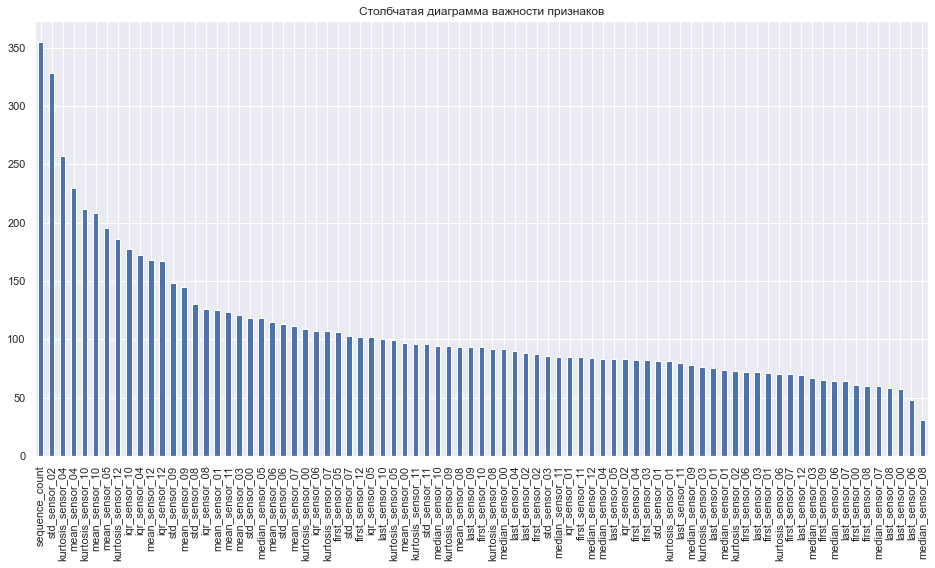

In [43]:
# Взглянем на важность признаков.
importance(model, X)

In [44]:
# Подготовим наш сабмишн.
submission = pd.DataFrame()
submission['sequence'] = sample_submission['sequence']
submission['state'] = predictions_probs[:, 1]
display(submission)

,sequence,state
0,25968,0.870803
1,25969,0.928190
2,25970,0.007443
3,25971,0.875579
4,25972,0.578975
...,...,...
12213,38181,0.887539
12214,38182,0.326990
12215,38183,0.781097
12216,38184,0.004622


In [45]:
submission.to_csv('submission.csv', index=False)